# Instrumental variables regression

files needed = ('card.dta', )

We introduce the **linearmodels** package in this notebook [(docs)](https://bashtage.github.io/linearmodels/doc/). The linearmodels package is built on top of statsmodels and provides us with extended functionality, including instrumental variables regressions and panel regressions. 

We will use linearmodels to perform instrumental variables regressions (two stage least squares). Along the way, we will practice using ols from statsmodels a bit, too. 

We need to install linearmodels. Open a command window and type 
```python
pip install --user linearmodels
```
then hit enter. 

In [1]:
import pandas as pd                    # for data handling
import numpy as np                     # for numerical methods and data structures
import matplotlib.pyplot as plt        # for plotting
import seaborn as sea                  # advanced plotting

import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas
import linearmodels.iv as iv           # built on statsmodels, this package provides iv in an easy way 

### Medical expenditure panel survey

Let's use data from the [medical expenditure panel survey](https://meps.ahrq.gov/mepsweb/). It surveys households, medical providers, and employers. There is a lot of interesting data here. 

The linearmodels package includes a dataset based on this data. Let's load it. You can see the variable list definitions [here](https://bashtage.github.io/linearmodels/doc/iv/examples/using-formulas.html). The example below is based on the example they provide. The data cover people over the age of 65.



In [2]:
from linearmodels.datasets import meps
med_exp = meps.load()
med_exp.head()

,ssiratio,age,educyr,drugexp,private,female,hisp,marry,vegood,good,...,priolist,totchr,black,hi_empunion,ldrugexp,age2,linc,vgh,fph,blhisp
0,0.149877,74,16,595,1,1,0,1,0,1,...,1,0,0,1,6.388561,5476.0,4.549085,1.0,0.0,0.0
1,0.395856,73,8,1783,1,0,0,1,0,1,...,1,3,0,1,7.486053,5329.0,3.577847,1.0,0.0,0.0
2,1.000000,80,12,176,0,1,0,0,0,0,...,1,1,0,0,5.170484,6400.0,2.261763,0.0,0.0,0.0
3,0.206639,70,17,2437,1,0,0,1,0,1,...,1,5,0,1,7.798523,4900.0,3.656221,1.0,0.0,0.0
4,0.537192,91,16,330,0,0,0,1,1,0,...,1,3,0,0,5.799093,8281.0,2.166193,1.0,0.0,0.0


In [3]:
# It's clean! 
med_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 29 columns):
ssiratio       10391 non-null float64
age            10391 non-null int64
educyr         10391 non-null int64
drugexp        10391 non-null int64
private        10391 non-null int64
female         10391 non-null int64
hisp           10391 non-null int64
marry          10391 non-null int64
vegood         10391 non-null int64
good           10391 non-null int64
fair           10391 non-null int64
poor           10391 non-null int64
poverty        10391 non-null int64
lowincome      10391 non-null int64
midincome      10391 non-null int64
msa            10391 non-null int64
firmsz         10391 non-null float64
multlc         10391 non-null int64
income         10391 non-null float64
priolist       10391 non-null int64
totchr         10391 non-null int64
black          10391 non-null int64
hi_empunion    10391 non-null int64
ldrugexp       10391 non-null float64
age2           1039

In [4]:
# But there are a few nans. Drop them.
med_exp = med_exp.dropna()

### OLS
We would like to understand the impact of employer (or union) provided healthcare on drug expenditure. 

$$\log(\text{drugexp}) = \beta_0 + \beta_1 \text{linc} + \beta_2 \text{hi_empunion} + \epsilon .$$

Start with ols.

In [5]:
res_ols = smf.ols('np.log(drugexp) ~ linc + hi_empunion', data=med_exp).fit(cov_type = 'HC3')
print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log(drugexp)   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.917
Date:                Mon, 19 Nov 2018   Prob (F-statistic):            0.00270
Time:                        16:08:14   Log-Likelihood:                -17427.
No. Observations:               10089   AIC:                         3.486e+04
Df Residuals:                   10086   BIC:                         3.488e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.4943      0.043    149.886      

The coefficient on employer health insurance is positive. People who had insurance through work spend more on drugs in their old age...or do they?

### Instrumental variables 

The concern is that *hi_empunion* is not exogenous. We will use *ssiratio* as an instrument for *hi_emp_union*. The purpose of the instrument is to remove the endogeneity of *hi_empunion.* A good instrument is

1. Correlated with the endogenous variable (in this case, *hi_empunion*) 
2. Uncorrelated with the error term

We can test the first condition. Regress 

$$\text{hi_empunion} =  \beta_1 \text{ssiratio} + \nu .$$

In [6]:
res_s1 = smf.ols('hi_empunion ~  ssiratio + linc', data=med_exp).fit(cov_type = 'HC3')
print(res_s1.summary())

                            OLS Regression Results                            
Dep. Variable:            hi_empunion   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     172.7
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           1.81e-74
Time:                        16:09:08   Log-Likelihood:                -6751.0
No. Observations:               10089   AIC:                         1.351e+04
Df Residuals:                   10086   BIC:                         1.353e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3440      0.029     11.771      0.0

It's significant, so it passes the the first test. The second test cannot generally be checked. 

### Two stage least squares

Note that our test of condition 1 generates fitted variables that are washed of their endogeneity. We can use the fitted variables in our original regression as an independent variable,

$$\log(\text{drugexp}) = \beta_0 + \beta_1 \text{linc} + \beta_2 \widehat{\text{hi_empunion}} + \epsilon .$$


We refer to the regression of *hi_empunion* on *ssiratio* as the **first stage regression** and the regression above as the **second stage regression**. In general, the two step procedure is

1. Regress the endogenous variable on the instrument(s)
2. Estimate the original model, after replacing the endogenous variable with the fitted values from step 1.


In [7]:
med_exp['fitted'] = res_s1.fittedvalues
med_exp['fitted'].describe()

count    10089.000000
mean         0.382198
std          0.113580
min         -1.690462
25%          0.278586
50%          0.388353
75%          0.474615
max          0.666728
Name: fitted, dtype: float64

In [8]:
res_s2 = smf.ols('np.log(drugexp) ~ linc + fitted', data=med_exp).fit(cov_type = 'HC3')
print(res_s2.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log(drugexp)   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     21.39
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           5.38e-10
Time:                        16:09:56   Log-Likelihood:                -17411.
No. Observations:               10089   AIC:                         3.483e+04
Df Residuals:                   10086   BIC:                         3.485e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6553      0.049    134.952      0.0

There are two problems with this procedure. 1. It's tedious. 2. The standard errors are not correct. 

Both of these problems are solved by using a two state least squares estimator. 

### 2SLS with linearmodels

We modify the patsy notation by specifying the endogenous variable and the instrument in square brackets. A couple minor differences in syntax compared to statsmodels. 

1. We need the `.from_formula` method if we are not specifying the design matrices directly. 
2. We need to include `1` to get the constant
3. There is not a named parameter `data`. We have to pass `from_formula( formual, data)`.

In [9]:
res_iv = iv.IV2SLS.from_formula('np.log(drugexp) ~ 1 + linc + [hi_empunion ~ ssiratio]', med_exp).fit()
print(res_iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:        np.log(drugexp)   R-squared:                     -0.2104
Estimator:                    IV-2SLS   Adj. R-squared:                -0.2106
No. Observations:               10089   F-statistic:                    34.458
Date:                Mon, Nov 19 2018   P-value (F-stat)                0.0000
Time:                        16:11:18   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       6.6553     0.0542     122.81     0.0000      6.5490      6.7615
linc            0.1058     0.0259     4.0858    

The point estimates are the same, but the standard errors differ. We can see the first-stage regression. Compare them to our first stage above. 

In [10]:
print(res_iv.first_stage)

    First Stage Estimation Results    
                           hi_empunion
--------------------------------------
R-squared                       0.0546
Partial R-squared               0.0238
Shea's R-squared                0.0238
Partial F-statistic             82.287
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                       0.3440
                              (12.092)
linc                            0.0572
                              (8.4496)
ssiratio                       -0.2211
                             (-9.0712)
--------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model


## Practice

Take a few minutes and try the following. Feel free to chat with those around you if you get stuck. The TA and I are here, too.

The file 'card.dta' contains data about individuals' wages and characteristics. The complete variable list is [here](http://fmwww.bc.edu/ec-p/data/wooldridge/card.des). 

1. Load the data. Make sure everything looks okay.

In [11]:
card = pd.read_stata("card.dta")
card.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,KWW,IQ,married,libcrd14,exper,lwage,expersq
0,2.0,0.0,0.0,7.0,29.0,NaN,NaN,158413.0,1.0,0.0,...,1.0,548.0,0.0,15.0,NaN,1.0,0.0,16.0,6.306275,256.0
1,3.0,0.0,0.0,12.0,27.0,8.0,8.0,380166.0,1.0,0.0,...,1.0,481.0,0.0,35.0,93.0,1.0,1.0,9.0,6.175867,81.0
2,4.0,0.0,0.0,12.0,34.0,14.0,12.0,367470.0,1.0,0.0,...,1.0,721.0,0.0,42.0,103.0,1.0,1.0,16.0,6.580639,256.0
3,5.0,1.0,1.0,11.0,27.0,11.0,12.0,380166.0,1.0,0.0,...,1.0,250.0,0.0,25.0,88.0,1.0,1.0,10.0,5.521461,100.0
4,6.0,1.0,1.0,12.0,34.0,8.0,7.0,367470.0,1.0,0.0,...,1.0,729.0,0.0,34.0,108.0,1.0,0.0,16.0,6.591674,256.0


2. Scatter plot log(wage) (y-axis) and educ (x-axis). \[The log is the natural log, np.log()\]

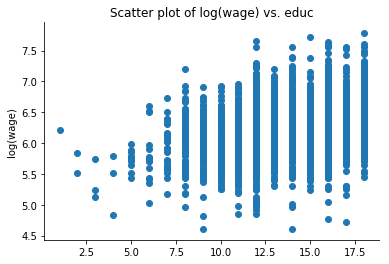

In [18]:
fig, ax = plt.subplots()

ax.scatter(x=card.educ, y=np.log(card.wage))
sea.despine(ax=ax)
ax.set_ylabel("log(wage)")
ax.set_title("Scatter plot of log(wage) vs. educ")

plt.show()

3. Regress wages on education. Use OLS.  

$$\log(\text{wage}) = \beta_0 + \beta_1 \text{educ} + \epsilon .$$

Make life interesting. Do not use the *lwage* variable. Roll your own. 

In [21]:
c_ols = smf.ols("np.log(wage) ~ educ", data=card).fit(cov_type = 'HC3')
print(c_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     320.5
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           3.47e-68
Time:                        16:16:06   Log-Likelihood:                -1668.8
No. Observations:                3010   AIC:                             3342.
Df Residuals:                    3008   BIC:                             3354.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5709      0.039    142.352      0.0

Consider the variable *nearc4* as an instrument. The variable is equal to 1 if the person grew up near a bachelor degree granting institution. 

4. Scatter plot *educ* (y-axis) and *nearc4* (x-axis). Is this plot very useful? \[If you finish early, come back to this plot and see if you can improve on it.\]

/Users/travis/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


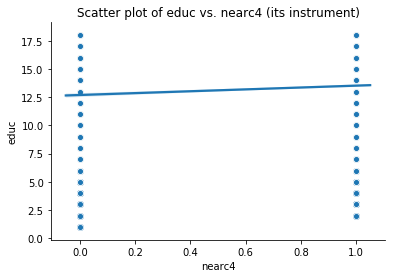

In [44]:
fig, ax = plt.subplots()

sea.regplot(ax=ax, x=card.nearc4, y=card.educ)
sea.scatterplot(ax=ax, x=card.nearc4, y=card.educ)
sea.despine(ax=ax)
ax.set_title("Scatter plot of educ vs. nearc4 (its instrument)")

plt.show()

5. Does *nearc4* satisfy the first condition for *nearc4* to be a good instrument for education?

In [25]:
rel = smf.ols("educ ~ nearc4", data=card).fit(cov_type = 'HC3')
print(rel.summary())

# Yes, the coefficient of nearc4 is statistically significant at 5% significance level when running the 
# regression against educ, so it is relevant

                            OLS Regression Results                            
Dep. Variable:                   educ   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     60.31
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           1.10e-14
Time:                        16:20:06   Log-Likelihood:                -7202.7
No. Observations:                3010   AIC:                         1.441e+04
Df Residuals:                    3008   BIC:                         1.442e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6980      0.090    140.645      0.0

6. Estimate  

$$\log(\text{wage}) = \beta_0 + \beta_1 \text{educ} + \epsilon .$$

using *nearc4* as an instrument for *educ*. Print out the results summary.

Make life interesting. Do not use the *lwage* variable. Roll your own. 

In [33]:
c_iv = iv.IV2SLS.from_formula("np.log(wage) ~ 1 + [educ ~ nearc4]", data=card).fit()
print(c_iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           np.log(wage)   R-squared:                     -0.5739
Estimator:                    IV-2SLS   Adj. R-squared:                -0.5744
No. Observations:                3010   F-statistic:                    51.784
Date:                Mon, Nov 19 2018   P-value (F-stat)                0.0000
Time:                        16:23:43   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.7675     0.3466     10.869     0.0000      3.0881      4.4468
educ           0.1881     0.0261     7.1961     0.00

7. Go nuts. Estimate 

$$\log(\text{wage}) = \beta_0 + \beta_1 \text{exper} + \beta_2 \text{exper}^2 + \beta_3 \text{black} + \beta_4 \text{smsa}+ \beta_5 \text{south} + \beta_6 \text{educ} + \epsilon .$$

Instrument *educ* with both *nearc4* and *nearc2*. 

Make life interesting. Do not use the *expersq* or *lwage* variables. Roll your own. 

In [45]:
c_iv2 = iv.IV2SLS.from_formula("np.log(wage) ~ 1 + exper + np.power(exper, 2) + black + smsa + south + [educ ~ nearc4 + nearc2]", data=card).fit()
print(c_iv2.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           np.log(wage)   R-squared:                      0.1455
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1438
No. Observations:                3010   F-statistic:                    720.37
Date:                Mon, Nov 19 2018   P-value (F-stat)                0.0000
Time:                        16:35:56   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept              3.2721     0.8169     4.0056     0.0001      1.6711      4.8732
exper               